<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/28_model_architecture_for_LLM_classification_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INITIALIZING A MODEL WITH PRETRAINED WEIGHTS

Steps:
1. Load pretrained GPT-2 weights
2. Modify the architecuture by adding a classification head.

### Code from previous notes with some rearrangements.

In [ ]:
#

import requests
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

class GPTModel(nn.Module):
    class LayerNorm(nn.Module):
      def __init__(self, emb_dim):
          super().__init__()
          self.eps = 1e-5
          self.scale = nn.Parameter(torch.ones(emb_dim))
          self.shift = nn.Parameter(torch.zeros(emb_dim))

      def forward(self, x):
          mean = x.mean(dim=-1, keepdim=True)
          var = x.var(dim=-1, keepdim=True, unbiased=False)
          norm_x = (x - mean) / torch.sqrt(var + self.eps)
          return self.scale * norm_x + self.shift

    class GELU(nn.Module):
      def __init__(self) -> None:
        super().__init__()

      def forward(self, x):
        # approx GeLu function
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

    class FeedForward(nn.Module):
      def __init__(self, cfg):
          super().__init__()
          self.layers = nn.Sequential(
              nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
              GPTModel.GELU(),
              nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
          )

      def forward(self, x):
          return self.layers(x)

    class MultiHeadAttention(nn.Module):
      def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
          super().__init__()
          assert (d_out % num_heads == 0), \
              "d_out must be divisible by num_heads"

          self.d_out = d_out
          self.num_heads = num_heads
          self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

          self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
          self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
          self.dropout = nn.Dropout(dropout)
          self.register_buffer(
              "mask",
              torch.triu(torch.ones(context_length, context_length),
                        diagonal=1)
          )

      def forward(self, x):
          b, num_tokens, d_in = x.shape

          keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
          queries = self.W_query(x)
          values = self.W_value(x)

          # We implicitly split the matrix by adding a `num_heads` dimension
          # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
          keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
          values = values.view(b, num_tokens, self.num_heads, self.head_dim)
          queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

          # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
          keys = keys.transpose(1, 2)
          queries = queries.transpose(1, 2)
          values = values.transpose(1, 2)

          # Compute scaled dot-product attention (aka self-attention) with a causal mask
          attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

          # Original mask truncated to the number of tokens and converted to boolean
          mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

          # Use the mask to fill attention scores
          attn_scores.masked_fill_(mask_bool, -torch.inf)

          attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
          attn_weights = self.dropout(  attn_weights)

          # Shape: (b, num_tokens, num_heads, head_dim)
          context_vec = (attn_weights @ values).transpose(1, 2)

          # Combine heads, where self.d_out = self.num_heads * self.head_dim
          context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
          context_vec = self.out_proj(context_vec) # optional projection

          return context_vec

    class TransformerBlock(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.att = GPTModel.MultiHeadAttention(
                d_in=cfg["emb_dim"],
                d_out=cfg["emb_dim"],
                context_length=cfg["context_length"],
                num_heads=cfg["n_heads"],
                dropout=cfg["drop_rate"],
                qkv_bias=cfg["qkv_bias"])
            self.ff = GPTModel.FeedForward(cfg)
            self.norm1 = GPTModel.LayerNorm(cfg["emb_dim"])
            self.norm2 = GPTModel.LayerNorm(cfg["emb_dim"])
            self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

        def forward(self, x):
            # Shortcut connection for attention block
            shortcut = x
            x = self.norm1(x)
            x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
            x = self.drop_shortcut(x)
            x = x + shortcut  # Add the original input back

            # Shortcut connection for feed forward block
            shortcut = x
            x = self.norm2(x)
            x = self.ff(x)
            x = self.drop_shortcut(x)
            x = x + shortcut  # Add the original input back

            return x

    # GPTModel itself
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[GPTModel.TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = GPTModel.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds

        # dropout helps in generalization and avoid overfitting
        x = self.drop_emb(x)
        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx



In [ ]:
class TokenUtils:
  @staticmethod
  def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

  @staticmethod
  def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


In [ ]:
import os
import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import numpy as np


class GPT2Weightloader:

  @staticmethod
  def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        GPT2Weightloader.download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = GPT2Weightloader.load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

  @staticmethod
  def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        response = requests.get(download_url, stream=True, timeout=60)
        response.raise_for_status()

        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size and file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return True

        block_size = 1024  # 1 KB
        desc = os.path.basename(download_url)
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=desc) as progress_bar:
            with open(destination, "wb") as file:
                for chunk in response.iter_content(chunk_size=block_size):
                    if chunk:
                        file.write(chunk)
                        progress_bar.update(len(chunk))
        return True

    try:
        if _attempt_download(url):
            return
    except requests.exceptions.RequestException:
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except requests.exceptions.RequestException:
                pass

        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

  # Alternative way using `requests`
  """
  def download_file(url, destination):
      # Send a GET request to download the file in streaming mode
      response = requests.get(url, stream=True)

      # Get the total file size from headers, defaulting to 0 if not present
      file_size = int(response.headers.get("content-length", 0))

      # Check if file exists and has the same size
      if os.path.exists(destination):
          file_size_local = os.path.getsize(destination)
          if file_size == file_size_local:
              print(f"File already exists and is up-to-date: {destination}")
              return

      # Define the block size for reading the file
      block_size = 1024  # 1 Kilobyte

      # Initialize the progress bar with total file size
      progress_bar_description = url.split("/")[-1]  # Extract filename from URL
      with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
          # Open the destination file in binary write mode
          with open(destination, "wb") as file:
              # Iterate over the file data in chunks
              for chunk in response.iter_content(block_size):
                  progress_bar.update(len(chunk))  # Update progress bar
                  file.write(chunk)  # Write the chunk to the file
  """

  @staticmethod
  def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

  @staticmethod
  def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

  @staticmethod
  def load_weights_into_gpt(gpt, params):
      gpt.pos_emb.weight = GPT2Weightloader.assign(gpt.pos_emb.weight, params['wpe'])
      gpt.tok_emb.weight = GPT2Weightloader.assign(gpt.tok_emb.weight, params['wte'])

      for b in range(len(params["blocks"])):
          q_w, k_w, v_w = np.split(
              (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
          gpt.trf_blocks[b].att.W_query.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_query.weight, q_w.T)
          gpt.trf_blocks[b].att.W_key.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_key.weight, k_w.T)
          gpt.trf_blocks[b].att.W_value.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_value.weight, v_w.T)

          q_b, k_b, v_b = np.split(
              (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
          gpt.trf_blocks[b].att.W_query.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_query.bias, q_b)
          gpt.trf_blocks[b].att.W_key.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_key.bias, k_b)
          gpt.trf_blocks[b].att.W_value.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.W_value.bias, v_b)

          gpt.trf_blocks[b].att.out_proj.weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.out_proj.weight,
              params["blocks"][b]["attn"]["c_proj"]["w"].T)
          gpt.trf_blocks[b].att.out_proj.bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].att.out_proj.bias,
              params["blocks"][b]["attn"]["c_proj"]["b"])

          gpt.trf_blocks[b].ff.layers[0].weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[0].weight,
              params["blocks"][b]["mlp"]["c_fc"]["w"].T)
          gpt.trf_blocks[b].ff.layers[0].bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[0].bias,
              params["blocks"][b]["mlp"]["c_fc"]["b"])
          gpt.trf_blocks[b].ff.layers[2].weight = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[2].weight,
              params["blocks"][b]["mlp"]["c_proj"]["w"].T)
          gpt.trf_blocks[b].ff.layers[2].bias = GPT2Weightloader.assign(
              gpt.trf_blocks[b].ff.layers[2].bias,
              params["blocks"][b]["mlp"]["c_proj"]["b"])

          gpt.trf_blocks[b].norm1.scale = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm1.scale,
              params["blocks"][b]["ln_1"]["g"])
          gpt.trf_blocks[b].norm1.shift = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm1.shift,
              params["blocks"][b]["ln_1"]["b"])
          gpt.trf_blocks[b].norm2.scale = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm2.scale,
              params["blocks"][b]["ln_2"]["g"])
          gpt.trf_blocks[b].norm2.shift = GPT2Weightloader.assign(
              gpt.trf_blocks[b].norm2.shift,
              params["blocks"][b]["ln_2"]["b"])

      gpt.final_norm.scale = GPT2Weightloader.assign(gpt.final_norm.scale, params["g"])
      gpt.final_norm.shift = GPT2Weightloader.assign(gpt.final_norm.shift, params["b"])
      gpt.out_head.weight = GPT2Weightloader.assign(gpt.out_head.weight, params["wte"])


### Fine tuning data loaders from previous notes as one class.

In [ ]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path
import pandas as pd


class SpamDatasetPreparer:
    def __init__(self,
                 url="https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip",
                 zip_path="sms_spam_collection.zip",
                 extracted_path="sms_spam_collection",
                 data_file_name="SMSSpamCollection.tsv"):

        self.url = url
        self.zip_path = Path(zip_path)
        self.extracted_path = Path(extracted_path)
        self.data_file_path = self.extracted_path / data_file_name

    def download_and_unzip(self):
        """Downloads and extracts the dataset if not already present."""
        if self.data_file_path.exists():
            print(f"{self.data_file_path} already exists. Skipping download and extraction.")
            return

        ssl_context = ssl._create_unverified_context()

        # Download the zip
        print("Downloading dataset...")
        with urllib.request.urlopen(self.url, context=ssl_context) as response:
            with open(self.zip_path, "wb") as out_file:
                out_file.write(response.read())

        # Unzip the file
        print("Extracting dataset...")
        with zipfile.ZipFile(self.zip_path, "r") as zip_ref:
            zip_ref.extractall(self.extracted_path)

        # Rename extracted file to .tsv
        original_file_path = self.extracted_path / "SMSSpamCollection"
        os.rename(original_file_path, self.data_file_path)
        print(f"File downloaded and saved as {self.data_file_path}")

    def load_dataframe(self):
        """Loads the TSV file into a DataFrame."""
        df = pd.read_csv(self.data_file_path, sep="\t", header=None, names=["Label", "Text"])
        return df

    def create_balanced_dataset(self, df):
        """Creates a balanced dataset with equal spam and ham samples."""
        num_spam = df[df["Label"] == "spam"].shape[0]
        ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
        balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
        balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
        return balanced_df

    def random_split(self, df, train_frac=0.7, validation_frac=0.1):
        """Randomly splits dataset into train, validation, and test sets."""
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        train_end = int(len(df) * train_frac)
        validation_end = train_end + int(len(df) * validation_frac)

        train_df = df[:train_end]
        validation_df = df[train_end:validation_end]
        test_df = df[validation_end:]
        return train_df, validation_df, test_df

    def prepare(self):
        """Full pipeline: download, load, balance, split, and save CSVs."""
        self.download_and_unzip()
        df = self.load_dataframe()
        balanced_df = self.create_balanced_dataset(df)
        train_df, validation_df, test_df = self.random_split(balanced_df)

        # Save splits
        train_df.to_csv("train.csv", index=False)
        validation_df.to_csv("validation.csv", index=False)
        test_df.to_csv("test.csv", index=False)

        print("Datasets saved: train.csv, validation.csv, test.csv")
        return train_df, validation_df, test_df


preparer = SpamDatasetPreparer()
train_df, val_df, test_df = preparer.prepare()

print(len(train_df))
print(len(val_df))
print(len(test_df))

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.
Datasets saved: train.csv, validation.csv, test.csv
1045
149
300


In [ ]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

120


In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [ ]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = GPT2Weightloader.download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
GPT2Weightloader.load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
text_1 = "Every effort moves you"

token_ids = generate(
    model=model,
    idx=TokenUtils.text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(TokenUtils.token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


Now, before we start finetuning the model as a spam classifier, let's see if the model can
perhaps already classify spam messages by by prompting it with instructions:

In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate(
    model=model,
    idx=TokenUtils.text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(TokenUtils.token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Based on the output, it's apparent that the model struggles with following instructions.

This is anticipated, as it has undergone only pretraining and lacks instruction-finetuning yet.

The next section prepares the model for classification-finetuning.

### Next step: Modify architecture by adding a classification head

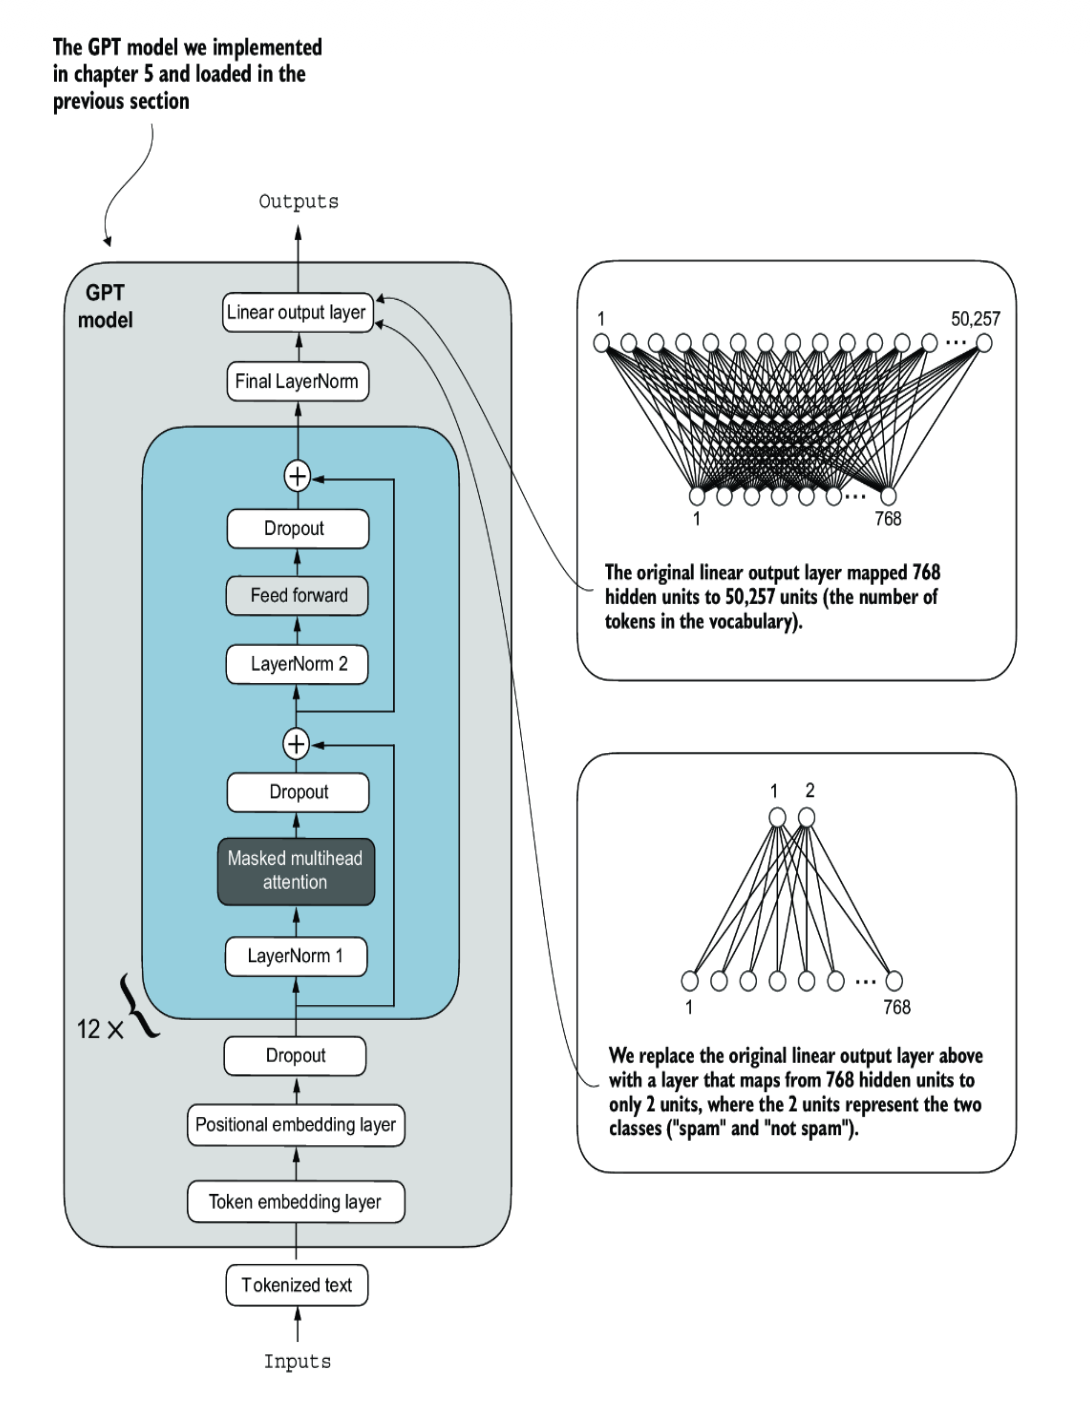

### select which layers you want to finetune:

- since we start with a pretrained model, it is not necessary to finetune all layers.
- This is because the lower layers capture basic language structures and semantics, which are applicable across a wide.
- So finetuning last layers is enough.

We will finetune:
- final output head
- final transformer block
- final layerNorm module.

We will freeze all other parameters.

We could technically use a single output node since we are dealing with a binary classification task.

However, this would require modifying the loss function.

Therefore, we choose a more general approach where the number of output nodes matches the number of classes.

For example, for a 3-class problem, such as classifying news articles as "Technology", "Sports", or "Politics", we would use three output nodes, and so forth.

In [28]:
# print original model architecture
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

To get the model ready for classification-finetuning, we first freeze the model, meaning that we make all layers non-trainable:


In [29]:
for param in model.parameters():
    param.requires_grad = False

In [30]:
# Then, we replace the output layer (model.out_head),
# which originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary):

torch.manual_seed(123)
torch.cuda.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

This new model.out_head output layer has its requires_grad attribute set to True by default, which means that it's the only layer in the model that will be updated during training.

We will configure the last transformer block and the final LayerNorm module, which connects this block to the output layer, to be trainable.

In [31]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True


Even though we added a new output layer and marked certain layers as trainable or nontrainable, we can still use this model in a similar way to previous notes.

For instance, we can feed it an example text identical to how we have done it in earlier chapters. For example, consider the following example text:

In [32]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [33]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


Remember that we are interested in finetuning this model so that it returns a class label that indicates whether a model input is spam or not spam.

To achieve this, we don't need to finetune all 4 output rows but can focus on a single output token.

In particular, we will focus on the last row corresponding to the last output token.

In [34]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])
